# Quarterly Industry Time Series Meta Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp

In [2]:
np.random.seed(1999)
w.simplefilter("ignore")

## Builds Meta Target

We define $$OWA_0 := mean\{OWA_{trotta}, OWA_{alves}, OWA_{muk}, OWA_{rnn}, OWA_{pelka}, OWA_{mlp}\}$$ and $$OWA_1 := mean\{OWA_{theta}, OWA_{arima}, OWA_{damped}, OWA_{ets}, OWA_{holt}, OWA_{ses}\}$$ as the group 0 and group 1 errors, respectively. The meta target is given by: $$Y=\mathbb{I}\{OWA_0 < OWA_1\}$$

In [60]:
trotta = pd.read_csv("../Metrics/trotta.csv", index_col=0)
alves = pd.read_csv("../Metrics/alves.csv", index_col=0)
muk = pd.read_csv("../Metrics/muk.csv", index_col=0)
rnn = pd.read_csv("../Metrics/rnn.csv", index_col=0)
pelka = pd.read_csv("../Metrics/pelka.csv", index_col=0)
mlp = pd.read_csv("../Metrics/mlp.csv", index_col=0)
theta = pd.read_csv("../Metrics/theta.csv", index_col=0)
arima = pd.read_csv("../Metrics/arima.csv", index_col=0)
damped = pd.read_csv("../Metrics/damped.csv", index_col=0)
ets = pd.read_csv("../Metrics/ets.csv", index_col=0)
holt = pd.read_csv("../Metrics/holt.csv", index_col=0)
ses = pd.read_csv("../Metrics/ses.csv", index_col=0)

In [62]:
mask = trotta.index.str.startswith("Q")

group0 = np.array(
    [
        trotta[mask]["OWA"], alves[mask]["OWA"], muk[mask]["OWA"], rnn[mask]["OWA"], pelka[mask]["OWA"], mlp[mask]["OWA"]
    ]
).T
group0 = np.apply_along_axis(np.mean, 1, group0)

group1 = np.array(
    [
        theta[mask]["OWA"], arima[mask]["OWA"], damped[mask]["OWA"], ets[mask]["OWA"], holt[mask]["OWA"], ses[mask]["OWA"]
    ]
).T
group1 = np.apply_along_axis(np.mean, 1, group1)

target = (group1 < group0).astype("int")

## Builds the Meta Dataset

It just concatenates the meta features extracted using the ts-pymfe module

In [63]:
groups = os.listdir("../Meta Features/groups")
groups = [file_name.split(".")[0] for file_name in groups]
    
data = []
for group in groups:
    df = pd.read_csv("../Meta Features/Quarterly/"+group+".csv", index_col=0)
    data.append(df)

df = pd.concat(data, axis=1)
df["target"] = target
df.index = trotta.index[mask]

In [64]:
df.head()

,itrand_acf.mean,itrand_acf.sd,itrand_mean.mean,itrand_mean.sd,itrand_sd.mean,itrand_sd.sd,resample_first_acf_locmin.mean,resample_first_acf_locmin.sd,resample_first_acf_nonpos.mean,resample_first_acf_nonpos.sd,...,gresid_lbtest.sd,pacf.mean,pacf.sd,pacf_detrended.mean,pacf_detrended.sd,pacf_diff.mean,pacf_diff.sd,tc3,trev,target
M4id,,,,,,,,,,,,,,,,,,,,,
Q13194,0.199977,0.310148,7039.470974,58.289196,521.607860,27.876489,NaN,NaN,2.0,0.0,...,0.076307,0.399837,0.458359,0.200558,0.391023,0.200558,0.391023,0.997270,-1.028514,1
Q13195,0.108026,0.313458,7567.418679,88.907116,494.651959,21.701125,NaN,NaN,2.0,0.0,...,0.027457,0.460382,0.466834,0.292765,0.331410,0.292765,0.331410,0.998055,-1.360875,1
Q13196,0.123783,0.301141,7295.080494,73.411909,452.142325,29.727639,NaN,NaN,2.0,0.0,...,0.159885,0.377442,0.518067,-0.285744,0.211623,-0.285744,0.211623,0.995062,-1.872936,1
Q13197,0.008315,0.352115,7106.866782,72.172612,407.092305,73.932985,NaN,NaN,2.0,0.0,...,0.205198,0.293668,0.616591,0.236492,0.499109,0.236492,0.499109,1.000964,-0.252565,1
Q13198,0.222095,0.319726,7643.124404,124.551987,547.575754,67.566347,NaN,NaN,2.0,0.0,...,0.032027,0.177944,0.754076,-0.187636,0.075444,-0.187636,0.075444,1.002818,-1.768906,1


In [65]:
df.shape

(4637, 238)

## Data Cleaning

The following steps are applied:
- Transforms complex valued features into real
- Drops features with more than 50 missing values
- Drops rows with at least one missing value
- Drops constant features
- Drops high correlated features

Afterwards, we are left with 4534 samples and 118 features.

In [66]:
df.dtypes[df.dtypes=="object"]

low_freq_power       object
ps_residuals.mean    object
ps_residuals.sd      object
dtype: object

In [67]:
df["low_freq_power"] = df["low_freq_power"].apply(lambda x:complex(x).real)
df["ps_residuals.mean"] = df["ps_residuals.mean"].apply(lambda x:complex(x).real)
df["ps_residuals.sd"] = df["ps_residuals.sd"].apply(lambda x:complex(x).real)

In [68]:
isnan = df.isna().sum()
nan_threshold = 50
df.drop(isnan[isnan>=nan_threshold].index, axis=1, inplace=True)

rows_to_drop = df[df.isna().any(axis=1)].index
df.drop(rows_to_drop, axis=0, inplace=True)

df.isna().sum().sum()

0

In [69]:
df.shape

(4534, 152)

In [70]:
df_std = df.std()
const_threshold = 1e-2
df.drop(df_std[df_std<const_threshold].index, axis=1, inplace=True)

In [71]:
df.shape

(4534, 151)

In [72]:
corr_matrix = df.drop("target", axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
df.drop(to_drop, axis=1, inplace=True)
df.shape

(4534, 118)

## Target Inspection
There's a huge unbalanced between the classes with more than 80% of the time series being better modelled by a statistical model.

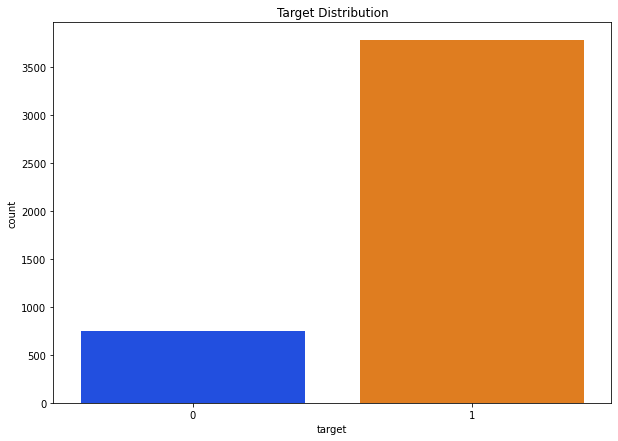

In [73]:
plt.figure(figsize=(10, 7))
plt.title("Target Distribution")
sns.countplot(df.target, palette="bright")
plt.show()

In [74]:
100*df.target.value_counts()/len(target)

1    81.561354
0    16.217382
Name: target, dtype: float64

## PCA Visualization
The PCA shows that the data is quite noisy, thus the best option is to use a robust linear model to fit it properly, even though it has no clusters that can be spoted visually.

In [75]:
X = df.drop("target", axis=1).values
y = df.target.values

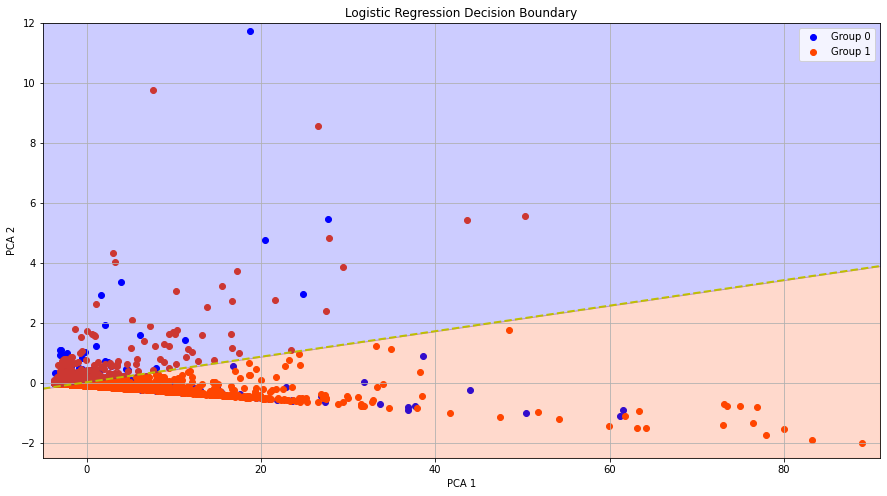

In [76]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform((X-X.mean())/X.std())

lr = LogisticRegression(penalty="l2", C=1.0, class_weight="balanced", solver="liblinear")
lr.fit(X_pca, y)

b = lr.intercept_[0]
w1, w2 = lr.coef_.T
c = -b/w2
m = -w1/w2


xmin, xmax = -5, 91
ymin, ymax = -2.5, 12
    
xd = np.array([xmin, xmax])
yd = m*xd + c

plt.figure(figsize=(15, 8))
plt.title("Logistic Regression Decision Boundary")
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color="blue", label="Group 0")
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color="orangered", label="Group 1")
plt.plot(xd, yd, 'y', lw=2, ls='--')
plt.fill_between(xd, yd, ymin, color='orangered', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='blue', alpha=0.2)
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.grid()

In [77]:
pca.explained_variance_ratio_

array([0.99742412, 0.00231324])

# Meta Learning Training

The procedure applies a LOO to get the predictions for all samples; the data is standardized and then fed to a Logistic Regression using a L1 heavy penalty to perform feature selection, then the 20 best features are selected to re-estimated the model coefficients using a L2 relaxed penalty, the latter is used to make predictions. The coefficients from the first model are also stored and then we will summarize them using the mean over all iterations to have a glimpse on which features the model considered as most important to tell the classes apart.

In [34]:
y_pred, y_true = [], []
coefs = []
for train_idxs, test_idxs in LeaveOneOut().split(X):
    X_train, y_train = X[train_idxs,:], y[train_idxs]
    X_test, y_test = X[test_idxs,:], y[test_idxs]
    
    std = StandardScaler()
    std.fit(X_train)
    X_train = std.transform(X_train)
    
    model = LogisticRegression(penalty="l1", C=0.25, class_weight="balanced", solver="liblinear")
    model.fit(X_train, y_train)
        
    coefs.append(model.coef_[0])
    
    fs = SelectFromModel(model, prefit=True, threshold=-np.inf, max_features=20)
    X_train = fs.transform(X_train)
        
    model = LogisticRegression(penalty="l2", C=1.0, class_weight="balanced", solver="liblinear")
    model.fit(X_train, y_train)
    
    X_test = std.transform(X_test)
    X_test = fs.transform(X_test)
    
    y_pred.append(model.predict(X_test)[0])
    y_true.append(y_test[0])

# Classification Metrics Evaluation

In [78]:
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred)*100:.2f} %")

Balanced Accuracy Score: 56.66 %


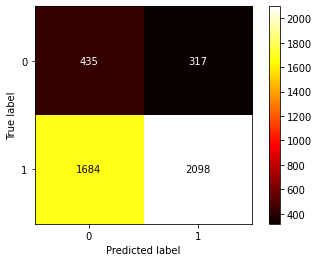

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap="hot")
plt.show()

# Feature Importances

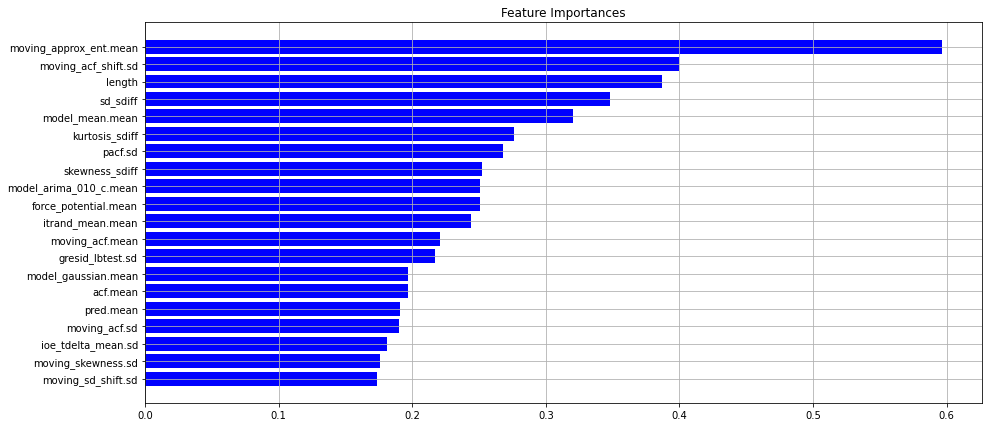

In [80]:
lr_coef = {
    "name":df.drop("target", axis=1).columns, 
    "score": np.array(coefs).mean(axis=0)
}
lr_coef = pd.DataFrame(lr_coef)
lr_coef["score"] = lr_coef["score"].abs()
lr_coef = lr_coef.sort_values(by="score", ascending=False)
to_plot = lr_coef[:20][::-1]
plt.figure(figsize=(15, 7))
plt.title("Feature Importances")
plt.barh(to_plot.name, to_plot.score, color="b")
plt.grid()

## Meta Learning Evaluation

The meta learner could not outperform the statistical group as shown in the following table:

In [81]:
trotta = trotta[mask].drop(rows_to_drop, axis=0)
alves = alves[mask].drop(rows_to_drop, axis=0)
muk = muk[mask].drop(rows_to_drop, axis=0)
rnn = rnn[mask].drop(rows_to_drop, axis=0)
pelka = pelka[mask].drop(rows_to_drop, axis=0)
mlp = mlp[mask].drop(rows_to_drop, axis=0)
theta = theta[mask].drop(rows_to_drop, axis=0)
arima = arima[mask].drop(rows_to_drop, axis=0)
damped = damped[mask].drop(rows_to_drop, axis=0)
ets = ets[mask].drop(rows_to_drop, axis=0)
holt = holt[mask].drop(rows_to_drop, axis=0)
ses = ses[mask].drop(rows_to_drop, axis=0)

In [83]:
mean = lambda x: np.apply_along_axis(np.mean, 1, x)
group0 = {
    "SMAPE":mean(np.array([trotta["SMAPE"], alves["SMAPE"], muk["SMAPE"], rnn["SMAPE"], pelka["SMAPE"], mlp["SMAPE"]]).T), 
    "MASE":mean(np.array([trotta["MASE"], alves["MASE"], muk["MASE"], rnn["MASE"], pelka["MASE"], mlp["MASE"]]).T), 
    "OWA":mean(np.array([trotta["OWA"], alves["OWA"], muk["OWA"], rnn["OWA"], pelka["OWA"], mlp["OWA"]]).T)
}
group1 = {
    "SMAPE":mean(np.array([theta["SMAPE"], arima["SMAPE"], damped["SMAPE"], ets["SMAPE"], holt["SMAPE"], ses["SMAPE"]]).T), 
    "MASE":mean(np.array([theta["MASE"], arima["MASE"], damped["MASE"], ets["MASE"], holt["MASE"], ses["MASE"]]).T), 
    "OWA":mean(np.array([theta["OWA"], arima["OWA"], damped["OWA"], ets["OWA"], holt["OWA"], ses["OWA"]]).T)
}


In [84]:
def meta_learner_metrics(group0:dict, group1:dict, predictions:np.ndarray)->dict:
    meta_learner = {"SMAPE":[], "MASE":[], "OWA":[]}
    for i, y in enumerate(predictions):
        if y==0:
            meta_learner["SMAPE"].append(group0["SMAPE"][i])
            meta_learner["MASE"].append(group0["MASE"][i])
            meta_learner["OWA"].append(group0["OWA"][i])
        else:
            meta_learner["SMAPE"].append(group1["SMAPE"][i])
            meta_learner["MASE"].append(group1["MASE"][i])
            meta_learner["OWA"].append(group1["OWA"][i])
        
    meta_learner["SMAPE"] = np.array(meta_learner["SMAPE"])
    meta_learner["MASE"] = np.array(meta_learner["MASE"])
    meta_learner["OWA"] = np.array(meta_learner["OWA"])
    return meta_learner

In [85]:
meta_learner = meta_learner_metrics(group0, group1, y_pred)
best_possible = meta_learner_metrics(group0, group1, y_true)

table = {
    "Group 0": [np.nanmean(group0["SMAPE"]),  np.nanmean(group0["MASE"]),  np.nanmean(group0["OWA"])],
    "Group 1": [np.nanmean(group1["SMAPE"]),  np.nanmean(group1["MASE"]),  np.nanmean(group1["OWA"])],
    "Meta Learner": [np.nanmean(meta_learner["SMAPE"]),  np.nanmean(meta_learner["MASE"]),  np.nanmean(meta_learner["OWA"])],
    "Best Possible": [np.nanmean(best_possible["SMAPE"]),  np.nanmean(best_possible["MASE"]),  np.nanmean(best_possible["OWA"])]
}
table = pd.DataFrame(table)
table.index = ["SMAPE", "MASE", "OWA"]
table.T

,SMAPE,MASE,OWA
Group 0,0.131609,1.704533,1.797919
Group 1,0.094953,1.173843,1.026385
Meta Learner,0.110850,1.363120,1.312828
Best Possible,0.091589,1.129085,1.002739


# Statistical Difference Between the Groups

Using the Kolmogorov-Smirnov test on 2 samples we noted that there is no significant difference between the application of the statistical models 100% of the time with the best possible we could get using meta learning for the SMAPE and the MASE, on the other hand, it is not true for the OWA.

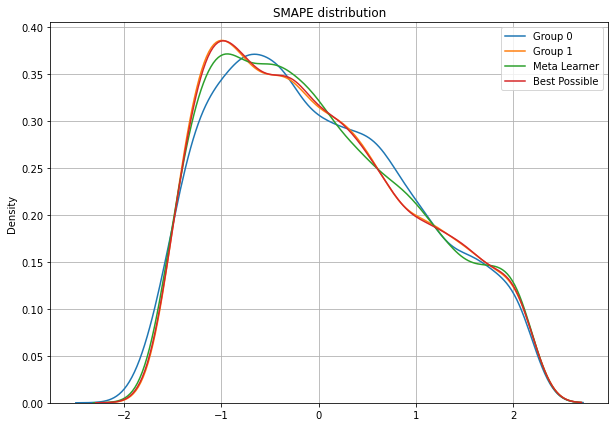

In [86]:
plt.figure(figsize=(10, 7))
plt.title("SMAPE distribution")
sns.distplot(power_transform(group0["SMAPE"].reshape(-1, 1)), label="Group 0", hist=False)
sns.distplot(power_transform(group1["SMAPE"].reshape(-1, 1)), label="Group 1", hist=False)
sns.distplot(power_transform(meta_learner["SMAPE"].reshape(-1, 1)), label="Meta Learner", hist=False)
sns.distplot(power_transform(best_possible["SMAPE"].reshape(-1, 1)), label="Best Possible", hist=False)
plt.legend()
plt.grid()

In [88]:
print(f"Group 0 x Meta Learner: \t{ks_2samp(group0['SMAPE'], meta_learner['SMAPE'])}")
print(f"Group 1 x Meta Learner: \t{ks_2samp(group1['SMAPE'], meta_learner['SMAPE'])}")
print(f"Group 0 x Group 1: \t\t{ks_2samp(group0['SMAPE'], group1['SMAPE'])}")
print(f"Group_0 x Best Possible: \t{ks_2samp(group0['SMAPE'], best_possible['SMAPE'])}")
print(f"Group_1 x Best Possible: \t{ks_2samp(group1['SMAPE'], best_possible['SMAPE'])}")

Group 0 x Meta Learner: 	KstestResult(statistic=0.11358623731804146, pvalue=6.983148462573097e-26)
Group 1 x Meta Learner: 	KstestResult(statistic=0.06793118659020732, pvalue=1.6157485908993633e-09)
Group 0 x Group 1: 		KstestResult(statistic=0.17931186590207324, pvalue=4.49494836940273e-64)
Group_0 x Best Possible: 	KstestResult(statistic=0.18967798853109838, pvalue=1.0826920340175136e-71)
Group_1 x Best Possible: 	KstestResult(statistic=0.015659461843846492, pvalue=0.6346439242253277)


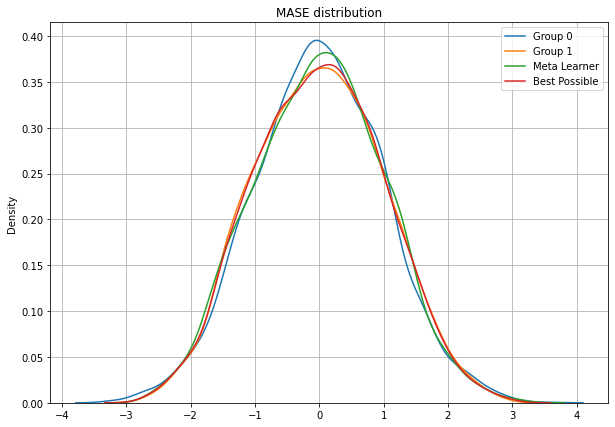

In [89]:
plt.figure(figsize=(10, 7))
plt.title("MASE distribution")
sns.distplot(power_transform(group0["MASE"].reshape(-1, 1)), label="Group 0", hist=False)
sns.distplot(power_transform(group1["MASE"].reshape(-1, 1)), label="Group 1", hist=False)
sns.distplot(power_transform(meta_learner["MASE"].reshape(-1, 1)), label="Meta Learner", hist=False)
sns.distplot(power_transform(best_possible["MASE"].reshape(-1, 1)), label="Best Possible", hist=False)
plt.legend()
plt.grid()

In [90]:
print(f"Group 0 x Meta Learner: \t{ks_2samp(group0['MASE'], meta_learner['MASE'])}")
print(f"Group 1 x Meta Learner: \t{ks_2samp(group1['MASE'], meta_learner['MASE'])}")
print(f"Group 0 x Group 1: \t\t{ks_2samp(group0['MASE'], group1['MASE'])}")
print(f"Group_0 x Best Possible: \t{ks_2samp(group0['MASE'], best_possible['MASE'])}")
print(f"Group_1 x Best Possible: \t{ks_2samp(group1['MASE'], best_possible['MASE'])}")

Group 0 x Meta Learner: 	KstestResult(statistic=0.17048963387737098, pvalue=6.192627548706569e-58)
Group 1 x Meta Learner: 	KstestResult(statistic=0.12284958094397883, pvalue=3.247616526082669e-30)
Group 0 x Group 1: 		KstestResult(statistic=0.29223643581826203, pvalue=4.747900575461361e-171)
Group_0 x Best Possible: 	KstestResult(statistic=0.3089986766651963, pvalue=1.5896245497137722e-191)
Group_1 x Best Possible: 	KstestResult(statistic=0.021393912659902956, pvalue=0.2505821600988841)


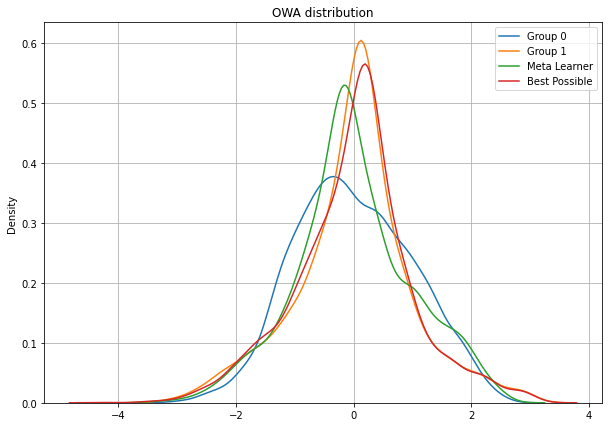

In [91]:
plt.figure(figsize=(10, 7))
plt.title("OWA distribution")
sns.distplot(power_transform(group0["OWA"].reshape(-1, 1)), label="Group 0", hist=False)
sns.distplot(power_transform(group1["OWA"].reshape(-1, 1)), label="Group 1", hist=False)
sns.distplot(power_transform(meta_learner["OWA"].reshape(-1, 1)), label="Meta Learner", hist=False)
sns.distplot(power_transform(best_possible["OWA"].reshape(-1, 1)), label="Best Possible", hist=False)
plt.legend()
plt.grid()

In [92]:
print(f"Group 0 x Meta Learner: \t{ks_2samp(group0['OWA'], meta_learner['OWA'])}")
print(f"Group 1 x Meta Learner: \t{ks_2samp(group1['OWA'], meta_learner['OWA'])}")
print(f"Group 0 x Group 1: \t\t{ks_2samp(group0['OWA'], group1['OWA'])}")
print(f"Group_0 x Best Possible: \t{ks_2samp(group0['OWA'], best_possible['OWA'])}")
print(f"Group_1 x Best Possible: \t{ks_2samp(group1['OWA'], best_possible['OWA'])}")

Group 0 x Meta Learner: 	KstestResult(statistic=0.23268636965152184, pvalue=5.214411014892385e-108)
Group 1 x Meta Learner: 	KstestResult(statistic=0.1623290692545214, pvalue=1.547147453061072e-52)
Group 0 x Group 1: 		KstestResult(statistic=0.39126599029554476, pvalue=4.84931186584003e-310)
Group_0 x Best Possible: 	KstestResult(statistic=0.3992059991177768, pvalue=4e-323)
Group_1 x Best Possible: 	KstestResult(statistic=0.044993383325981476, pvalue=0.00020600929717282926)
